# Data Synthesis

In this notebook we'll demonstrate how `causal-validation` can be used to simulate
synthetic datasets. We'll start with very simple data to which a static treatment
effect may be applied. From there, we'll build up to complex datasets. Along the way,
we'll show how reproducibility can be ensured, plots can be generated, and unit-level
parameters may be specified.

In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import (
    norm,
    poisson,
)

from causal_validation import (
    Config,
    simulate,
)
from causal_validation.effects import StaticEffect
from causal_validation.plotters import plot
from causal_validation.transforms import (
    Periodic,
    Trend,
)
from causal_validation.transforms.parameter import UnitVaryingParameter

## Simulating a Dataset

Simulating a dataset is as simple as specifying a `Config` object and then invoking the `simulate` function. Control/treated units, pre/post treatment periods, as well as the treatment dosages are defined through a treatment assignment matrix. Once simulated, we may visualise the data through the `plot` function.

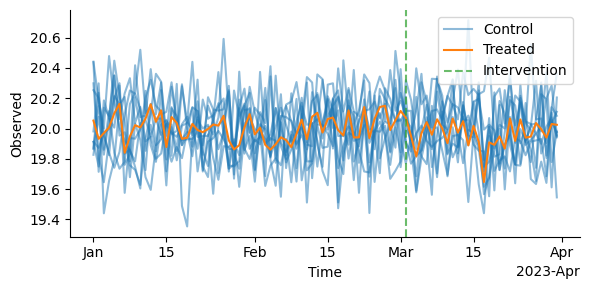

In [2]:
# Treatment assignment matrix
D = np.zeros((90, 11))  # 90 time points, 11 units
D[60:, -1] = 1  # Last unit treated after 60 time points

cfg = Config(treatment_assignments=D)

data = simulate(cfg)
ax = plot(data)

### Controlling baseline behaviour

We observe that we have 10 control units, each of which were sampled from a Gaussian
distribution with mean 20 and scale 0.2. Had we wished for our underlying observations
to have more or less noise, or to have a different global mean, then we can simply
specify that through the config file.

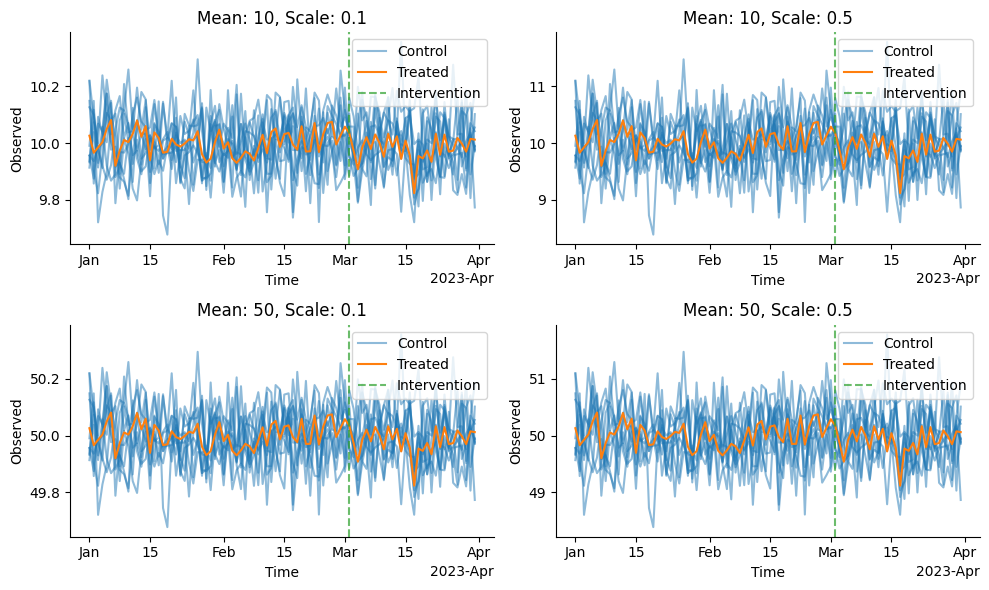

In [3]:
means = [10, 50]
scales = [0.1, 0.5]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6), tight_layout=True)
for (m, s), ax in zip(product(means, scales), axes.ravel(), strict=False):
    cfg = Config(
        treatment_assignments=D,
        global_mean=m,
        global_scale=s,
    )
    data = simulate(cfg)
    _ = plot(data, ax=ax, title=f"Mean: {m}, Scale: {s}")

### Reproducibility

In the above four panels, we can see that whilst the mean and scale of the underlying
data generating process is varying, the functional form of the data is the same. This
is by design to ensure that data sampling is reproducible. To sample a new dataset,
you may either change the underlying seed in the config file.

In [4]:
cfg = Config(
    treatment_assignments=D,
    seed=42,
)

Reusing the same config file across simulations

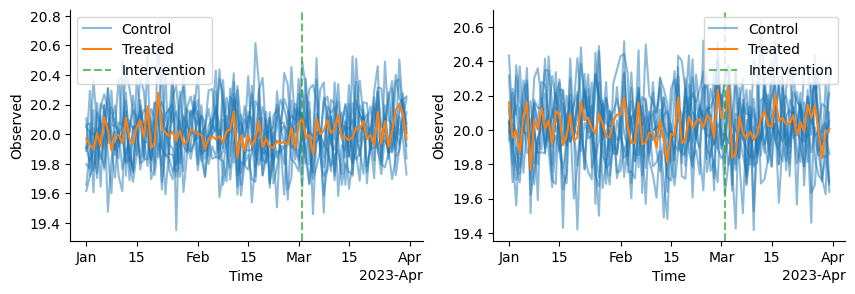

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
for ax in axes:
    data = simulate(cfg)
    _ = plot(data, ax=ax)

Or manually specifying and passing your own pseudorandom number generator key

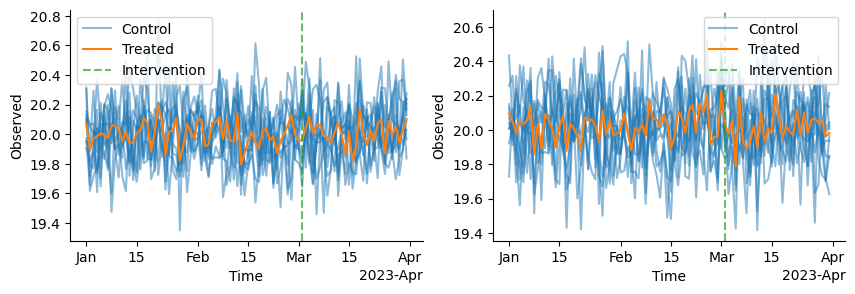

In [6]:
rng = np.random.RandomState(42)

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
for ax in axes:
    data = simulate(cfg, key=rng)
    _ = plot(data, ax=ax)

### Simulating an effect

In the data we have seen up until now, the treated unit has been drawn from the same
data generating process as the control units. However, it can be helpful to also
inflate the treated unit to observe how well our model can recover the the true
treatment effect. To do this, we simply compose our dataset with an `Effect` object.
In the below, we shall inflate our data by 2%.

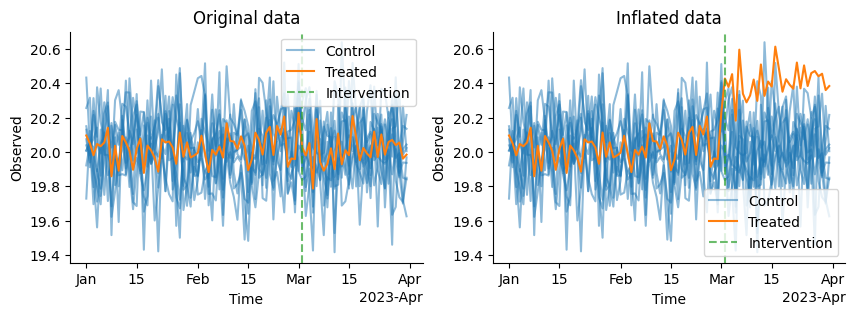

In [7]:
effect = StaticEffect(effect=0.02)
inflated_data = effect(data)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 3))
ax0 = plot(data, ax=ax0, title="Original data")
ax1 = plot(inflated_data, ax=ax1, title="Inflated data")

### More complex generation processes

The example presented above shows a very simple stationary data generation process.
However, we may make our example more complex by including a non-stationary trend to
the data.

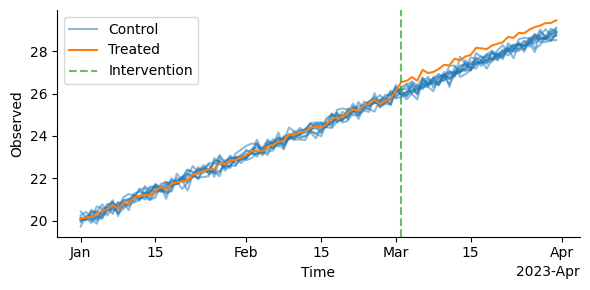

In [8]:
trend_term = Trend(degree=1, coefficient=0.1)
data_with_trend = effect(trend_term(data))
ax = plot(data_with_trend)

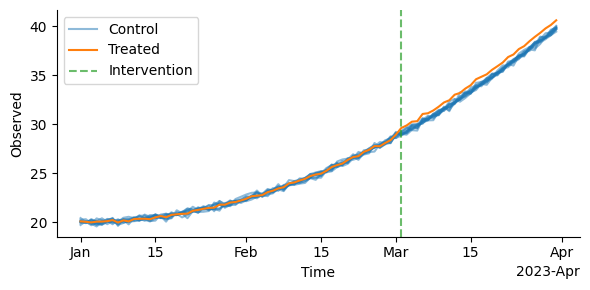

In [9]:
trend_term = Trend(degree=2, coefficient=0.0025)
data_with_trend = effect(trend_term(data))
ax = plot(data_with_trend)

We may also include periodic components in our data

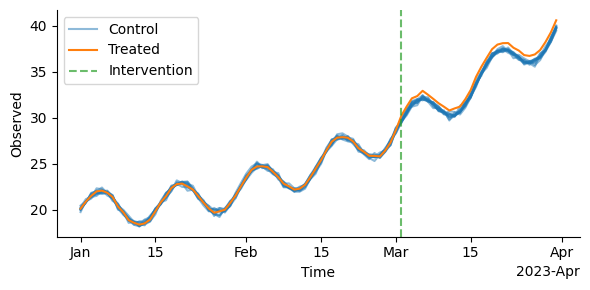

In [10]:
periodicity = Periodic(amplitude=2, frequency=6)
perioidic_data = effect(periodicity(trend_term(data)))
ax = plot(perioidic_data)

### Unit-level parameterisation

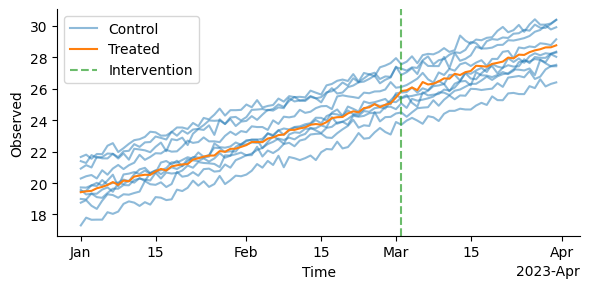

In [11]:
sampling_dist = norm(0.0, 1.0)
intercept = UnitVaryingParameter(sampling_dist=sampling_dist)
trend_term = Trend(degree=1, intercept=intercept, coefficient=0.1)
data_with_trend = effect(trend_term(data))
ax = plot(data_with_trend)

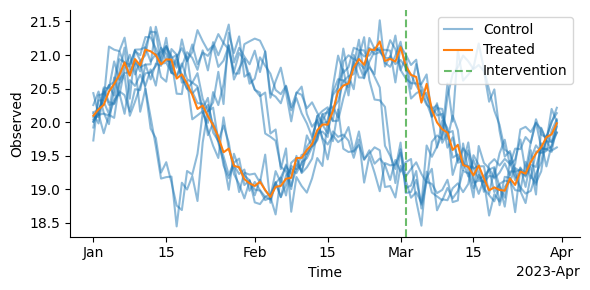

In [12]:
sampling_dist = poisson(2)
frequency = UnitVaryingParameter(sampling_dist=sampling_dist)

p = Periodic(frequency=frequency)
ax = plot(p(data))

## Conclusions

In this notebook we have shown how one can define their model's true underlying data
generating process, starting from simple white-noise samples through to more complex
example with periodic and temporal components, perhaps containing unit-level
variation. In a follow-up notebook, we show how these datasets may be integrated with
Amazon's own AZCausal library to compare the effect estimated by a model with the true
effect of the underlying data generating process. A link to this notebook is
[here](https://amazon-science.github.io/causal-validation/examples/azcausal/).